<a href="https://colab.research.google.com/github/gusujio/neural_networks_start/blob/master/%D0%B2%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BA%D0%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание цифр

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

## Скачаем dataset

In [ ]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.float()
X_test = X_test.float();

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Немного посмотрим на данные 

In [ ]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

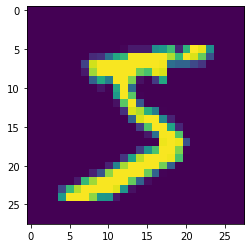

tensor(5)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [ ]:
X_train = X_train.reshape([-1, 28 * 28]) #превратим в одномерные массив
X_test = X_test.reshape([-1, 28 * 28])

In [ ]:
class MNISTNet(torch.nn.Module):#Наша нейронка
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid() # что бы добавить не линейность 
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [ ]:
torch.cuda.is_available() # torch видет gpu?

True

In [ ]:
!nvidia-smi
# мы можем посмотреть -- а занята ли наша видео-карточка какими-то вычислениями. Это делается с помощью консольной команды

Sun Jul 12 11:38:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    62W / 149W |   1947MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Работа с видеокартой
Какие же тензоры нам нужно переложить на видео карточку? Во-первых это веса нейронной сети -- это то, что будет оптимизироваться, это то, что участвует в вычислениях, это обязательно должно быть на видео карте. А кроме того нам нужно переложить на видео карту ещё и входы -- те картинки, которые мы передаём в нейросеть.

Во-первых нам нужно создать такую переменную "device", которая будет либо строчкой "cuda:0", что соответствует нулевой видео-карточке (если у вас их вдруг много), либо "cpu", если видео-карты нету. То есть сейчас мы создаем кросс-платформенный код, который будет работать и на CPU, и на GPU, в зависимости от того, что выдаст эта строчка. torch.cuda_is_available. Если будет True, то, соответственно, device превратится в "cuda:0", а если у вас "cuda_is_available" -- это False, значит будет CPU, как обычно.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Теперь нам нужно на этот device переложить нейронную сеть. (то есть как с обычным тензором)
mnist_net = mnist_net.to(device)
# Давайте убедимся, а переложилась ли наша нейронная сеть на GPU?
#  Это можно сделать, если мы возьмём её параметры, которые мы обычно передаём в оптимизатор, и просто выведем их на экран.
# И мы видим, что везде прописан device cuda:0, то есть это значит, что все эти параметры теперь лежат на видео-карте
# list(mnist_net.parameters())

loss - это будет кросс-энтропия, потому что это loss, который используется в классификации. Нужно подчеркнуть, что функция CrossEntropyLoss на вход принимает не вероятности, а те выходы, которые до софтмакса, то есть функция forward, которую мы написали, не содержала софтмакс, потому что мы хотим немножко ускорить наши вычисления, избежав софтмакса.

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
x=torch.zeros([6000, 28, 28], dtype=torch.int32)

Мы будем обучаться батчевым или стохастическим градиентным спуском. То есть мы будем делить наш датасет на маленькие части (так называемые батчи), передавать эти батчи в нейронную сеть с помощью функции forward. После этого мы будем вызывать loss-функцию, которая скажет нам размер ошибки. После этого мы сможем посчитать градиент с помощью функции backward, и дальше мы сможем сделать градиентный шаг, вызвав optimizer.step

In [ ]:
%%time
batch_size = 100

test_accuracy_history = [] # cохраняют значение на каждой эпохе
test_loss_history = []

loss_train_batch = []

# А кроме того нам нужно переложить на видео карту входные данные, 
# то есть мы можем взять, и весь наш тестовый датасет X_test сразу переложить на device,
#  потому что мы тестируемся по всему датасету сразу и считаем, 
#  что он помещается в видео-памяти. 

X_test = X_test.to(device) 
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        # А вот Y_train и X_train мы не будем сразу класть на видео-карту, 
        # мы будем это делать по батчам, то есть мы возьмём из датасета некоторый батч, и его будем перекладывать на видео карту.
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)

        loss_train_batch.append(loss_value)

        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test)) #будем сохранять наши лоссы на тесте
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)#будем сохранять наши accuracy
    print(accuracy)

tensor(0.9069, device='cuda:0')
tensor(0.9180, device='cuda:0')
tensor(0.9186, device='cuda:0')
tensor(0.9291, device='cuda:0')
tensor(0.9250, device='cuda:0')
tensor(0.9229, device='cuda:0')
tensor(0.9302, device='cuda:0')
tensor(0.9253, device='cuda:0')
tensor(0.9263, device='cuda:0')
tensor(0.9337, device='cuda:0')
tensor(0.9296, device='cuda:0')
tensor(0.9386, device='cuda:0')
tensor(0.9378, device='cuda:0')
tensor(0.9275, device='cuda:0')
tensor(0.9339, device='cuda:0')
tensor(0.9372, device='cuda:0')
tensor(0.9386, device='cuda:0')
tensor(0.9393, device='cuda:0')
tensor(0.9424, device='cuda:0')
tensor(0.9414, device='cuda:0')
tensor(0.9340, device='cuda:0')
tensor(0.9373, device='cuda:0')
tensor(0.9343, device='cuda:0')
tensor(0.9429, device='cuda:0')
tensor(0.9427, device='cuda:0')
tensor(0.9434, device='cuda:0')
tensor(0.9461, device='cuda:0')
tensor(0.9481, device='cuda:0')
tensor(0.9454, device='cuda:0')
tensor(0.9443, device='cuda:0')
tensor(0.9403, device='cuda:0')
tensor(0

мы видим, что обучение пошло гораздо быстрее (в несколько десятков раз). То есть обучение, которое происходит на видеокарточке, оно, как правило, в 10, 30, может быть даже в 50 раз будет быстрее, чем обучение, которое происходит на CPU.

2min 16s - 100 эпох на gpu

3min 34s - 100 эпох на cpu

2min 19s - 100 эпох на gpu c  torch.backends.cudnn.deterministic = False

Accuracy после 200 эпох (средняя по 5 экспериментам):

1. SGD - 0.9193
2. Rprop - 0.9271
3. RMSprop - 0.9616
4. Adam - 0.9596

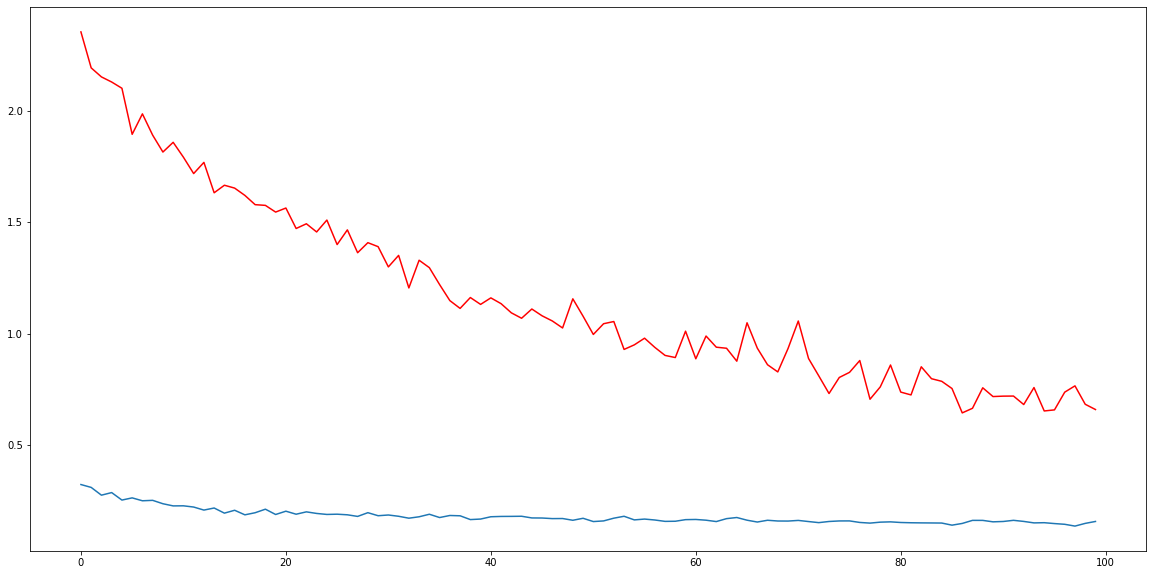

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(loss_train_batch[:len(test_loss_history)], color = 'r')
plt.plot(test_loss_history)

In [ ]:
test_preds.argmax(dim=1)

tensor([7, 2, 1,  ..., 4, 5, 6])